In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import json
from sklearn.cluster import DBSCAN

In [2]:
date_columns = ['property_scraped_at', 'host_since', 'reviews_first', 'reviews_last']
train_df = pd.read_csv("train.csv", parse_dates=date_columns)
#train_df.dropna(subset=['property_zipcode'], inplace=True)
train_df = train_df[(train_df.property_zipcode.str.len() == 4)]
train_df['property_zipcode'] = train_df['property_zipcode'].astype(int)
train_df = train_df[train_df.target < 385]

In [6]:
with open("belgium_2.geojson", encoding='utf-8', errors='ignore') as json_data:
     belgium_geocode = json.load(json_data, strict=False)

import requests
my_link = "https://www.mapsofworld.com/postal-codes/belgium/vlaanderen/antwerpen.html"

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(my_link, headers=header)

df_xyz = pd.read_html(r.text)
antwerp_zipcodes = pd.DataFrame(df_xyz[2].iloc[1:].values, columns = df_xyz[2].iloc[0].values)
antwerp_zipcodes['Zipcode'] = antwerp_zipcodes['Zipcode'].astype(int)

In [8]:
antwerp_df = train_df[train_df.property_zipcode.isin(antwerp_zipcodes.Zipcode)]
brussels_df = train_df[~train_df.property_zipcode.isin(antwerp_zipcodes.Zipcode)]
train_df['city'] = 'Brussels'
train_df.loc[train_df.property_zipcode.isin(antwerp_zipcodes.Zipcode), 'city'] = 'Antwerp'

In [9]:
print(antwerp_df.shape[0])
print(brussels_df.shape[0])

1074
5260


In [10]:
antwerp_geocodes = [x for x in belgium_geocode.get('features') if x.get('properties').get("nouveau_PO") in antwerp_zipcodes.Zipcode.values]
brussels_geocodes = [x for x in belgium_geocode.get('features') if x.get('properties').get("nouveau_PO") in brussels_df.property_zipcode.values]

antwerp_geocodes = {"type":"FeatureCollection",
"features" : antwerp_geocodes}

brussels_geocodes = {"type":"FeatureCollection",
"features" : brussels_geocodes}

/var/folders/36/jz61tnqj2nd6cp2y8_cvcdlh0000gn/T/ipykernel_47354/3033028341.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  antwerp_geocodes = [x for x in belgium_geocode.get('features') if x.get('properties').get("nouveau_PO") in antwerp_zipcodes.Zipcode.values]
/var/folders/36/jz61tnqj2nd6cp2y8_cvcdlh0000gn/T/ipykernel_47354/3033028341.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  brussels_geocodes = [x for x in belgium_geocode.get('features') if x.get('properties').get("nouveau_PO") in brussels_df.property_zipcode.values]


ZIPCODE BREAKDOWN

clustering

In [ ]:
from math import sin, cos, sqrt, atan2, radians

from scipy.spatial.distance import pdist, squareform

def dist(x, y):
    """Function to compute the distance between two points x, y"""

    lat1 = radians(x[0])
    lon1 = radians(x[1])
    lat2 = radians(y[0])
    lon2 = radians(y[1])

    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return round(distance, 4)

def cluster_report(df):
    total_list = []
    for cluster_no in list(df.cluster.unique()):
        tmp_df = df.query(f"cluster == {cluster_no}")[['property_lat_x', 'property_lon_x']]
        distances = pdist(tmp_df.values, metric=dist)

        points = [f'point_{i}' for i in range(1, tmp_df.shape[0] + 1)]

        result = pd.DataFrame(squareform(distances), columns=points, index=points)
        n_matrix = len(points)
        max_distance = result.iloc[np.argmax(result) % n_matrix, np.argmax(result) // n_matrix]
        total_list.append([cluster_no, max_distance])

    a1 = pd.DataFrame(total_list, columns=['cluster', 'Max_Distance']).sort_values("Max_Distance", ascending=False).set_index("cluster")
    a2 = df.groupby('cluster')['target'].agg(['mean','median', 'count']).round(2)
    cluster_results = a1.join(a2)
    return cluster_results

loop_colors = [
    'red',
    'blue',
    'green',
    'purple',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

In [15]:
kms_per_radian = 6371.0088
radian_coordinates = np.radians(brussels_df[['property_lat', 'property_lon']])
db = DBSCAN( eps = 0.1 / kms_per_radian
            , min_samples = 30
            , algorithm='ball_tree'
            , metric='haversine').fit(radian_coordinates)
print(pd.DataFrame(db.labels_).value_counts().sort_index())

-1    4918
 0     236
 1      32
 2      43
 3      31
dtype: int64


cluster
0    236
1     32
2     43
3     31
dtype: int64


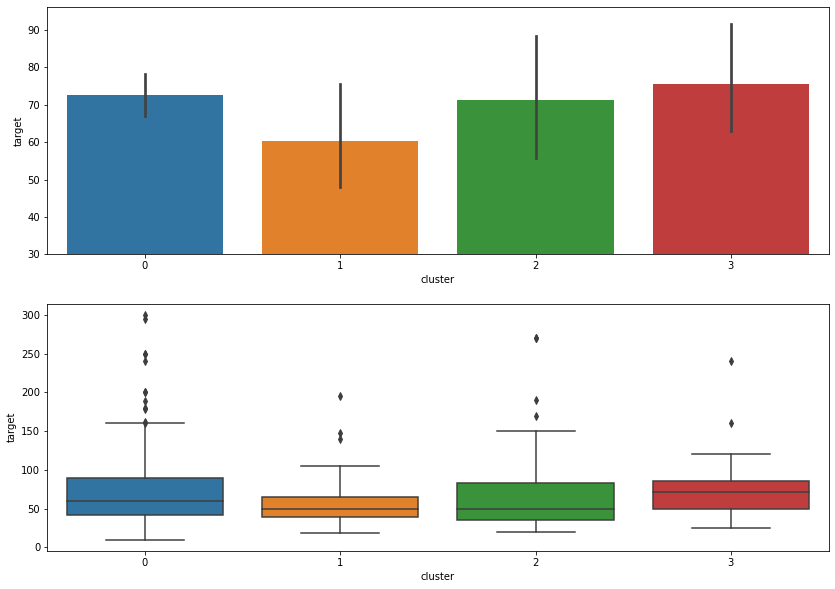

In [77]:
db_scan_clusters = pd.concat([radian_coordinates.reset_index(),pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
#brux_loop = brussels_df.merge(db_scan_clusters, left_index=True, right_on='index')
db_clusters_filtered = db_scan_clusters.query("cluster > -1")
brux_loop = brussels_df.merge(db_clusters_filtered, left_index=True, right_on='index')

print(db_clusters_filtered.groupby('cluster').size())

fig = plt.figure(figsize = (14,10))
ax = plt.subplot(2,1,1)
sns.barplot(data = brux_loop[['cluster', 'target']], x='cluster', y='target')
ax.set_ylim(30, None)

ax = plt.subplot(2,1,2)
sns.boxplot(data = brux_loop[['cluster', 'target']], x='cluster', y='target')
plt.show()


In [68]:
brussels_map = folium.Map(location=[50.8476, 4.3572], zoom_start=12)
folium.GeoJson(brussels_geocodes, name="geojson").add_to(brussels_map)

for i in list(brux_loop.cluster.unique()):
    loop_df = brux_loop.query(f"cluster == {i}")
    icon = folium.Icon(color=loop_colors[i])
    icone1 = folium.Icon(icon="asterisk", icon_color="#9b59b6", color="lightblue")
    
    for j in range(0,loop_df.shape[0]):
        folium.Marker(
            location=[loop_df.iloc[j]['property_lat_x'], loop_df.iloc[j]['property_lon_x']],
            popup= str(loop_df.iloc[j]['target']) + str(f"\n Cluster no: - {i}"),
            draggable=False
            , icon=folium.Icon(color=loop_colors[i])   
            ).add_to(brussels_map)

brussels_map

In [63]:

db_scan_clusters = pd.concat([radian_coordinates.reset_index(),pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
#brux_loop = brussels_df.merge(db_scan_clusters, left_index=True, right_on='index')
db_clusters_filtered = db_scan_clusters.query("cluster > -1")
brux_loop = brussels_df.merge(db_clusters_filtered, left_index=True, right_on='index')

print(db_clusters_filtered.groupby('cluster').size())

fig = plt.figure(figsize = (14,10))
ax = plt.subplot(2,1,1)
sns.barplot(data = brux_loop[['cluster', 'target']], x='cluster', y='target')
ax.set_ylim(30, None)

ax = plt.subplot(2,1,2)
sns.boxplot(data = brux_loop[['cluster', 'target']], x='cluster', y='target')
plt.show()

tmppp_df = brussels_df[~brux_loop.index]
radian_coordinates = tmppp_df[['property_lat_y','property_lon_y']]
db = DBSCAN(eps = 0.15 / kms_per_radian
            , min_samples= 10
            , algorithm='ball_tree'
            , metric='haversine').fit(radian_coordinates)
print(pd.DataFrame(db.labels_).value_counts().sort_index())
db_scan_clusters = pd.concat([radian_coordinates.reset_index(),pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
#brux_loop = brussels_df.merge(db_scan_clusters, left_index=True, right_on='index')
brux_loop = brux_2.drop('cluster', axis=1).merge(db_scan_clusters, left_index=True, right_on='index')

cluster_iteration2 = cluster_report(brux_loop)
cluster_iteration2.head(50)

In [ ]:

brussels_map = folium.Map(location=[50.8476, 4.3572], zoom_start=12)
folium.GeoJson(brussels_geocodes, name="geojson").add_to(brussels_map)

for i in list(brux_loop.cluster.unique()):
    loop_df = brux_loop.query(f"cluster == {i}")
    icon = folium.Icon(color=loop_colors[i])
    icone1 = folium.Icon(icon="asterisk", icon_color="#9b59b6", color="lightblue")
    
    for j in range(0,loop_df.shape[0]):
        folium.Marker(
            location=[loop_df.iloc[j]['property_lat_x'], loop_df.iloc[j]['property_lon_x']],
            popup= str(loop_df.iloc[j]['target']) + str(f"\n Cluster no: - {i}"),
            draggable=False
            , icon=folium.Icon(color=loop_colors[i])   
            ).add_to(brussels_map)

brussels_map